In [812]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sys
import random
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from gibbs import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [258]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb

In [259]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

In [591]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def forward(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
            #print('i: '+str(i))
            #print('x_ : '+str(x_))
            #print('s : '+str(s))
            #print('t : '+str(t))
            #print('x : '+str(x))
            #print()
        return x

    def backward(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            #print('i: '+str(i))
            #print('z_ : '+str(z_))
            #print('s : '+str(s))
            #print('t : '+str(t))
            #print('z : '+str(z))
            #print()
            log_det_J -= s.sum(dim=-1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.backward(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1)).float()
        logp = self.prior.log_prob(z)
        x = self.forward(z)
        return x

In [881]:
from torch.distributions import constraints
from torch.distributions.categorical import Categorical
from torch.distributions.utils import clamp_probs, broadcast_all
from torch.distributions.distribution import Distribution
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.transforms import ExpTransform

class ExpRelaxedCategorical(Distribution):
    r"""
    Creates a ExpRelaxedCategorical parameterized by
    :attr:`temperature`, and either :attr:`probs` or :attr:`logits` (but not both).
    Returns the log of a point in the simplex. Based on the interface to
    :class:`OneHotCategorical`.

    Implementation based on [1].

    See also: :func:`torch.distributions.OneHotCategorical`

    Args:
        temperature (Tensor): relaxation temperature
        probs (Tensor): event probabilities
        logits (Tensor): unnormalized log probability for each event

    [1] The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables
    (Maddison et al, 2017)

    [2] Categorical Reparametrization with Gumbel-Softmax
    (Jang et al, 2017)
    """
    arg_constraints = {'probs': constraints.simplex,
                       'logits': constraints.real_vector}
    support = constraints.real_vector  # The true support is actually a submanifold of this.
    has_rsample = True

    def __init__(self, temperature, probs=None, logits=None, validate_args=None):
        self._categorical = Categorical(probs, logits)
        self.temperature = temperature
        batch_shape = self._categorical.batch_shape
        event_shape = self._categorical.param_shape[-1:]
        super().__init__(batch_shape, event_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(ExpRelaxedCategorical, _instance)
        batch_shape = torch.Size(batch_shape)
        new.temperature = self.temperature
        new._categorical = self._categorical.expand(batch_shape)
        super(ExpRelaxedCategorical, new).__init__(batch_shape, self.event_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def _new(self, *args, **kwargs):
        return self._categorical._new(*args, **kwargs)

    @property
    def param_shape(self):
        return self._categorical.param_shape

    @property
    def logits(self):
        return self._categorical.logits

    @property
    def probs(self):
        return self._categorical.probs

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        uniforms = clamp_probs(torch.rand(shape, dtype=self.logits.dtype, device=self.logits.device))
        gumbels = -((-(uniforms.log())).log())
        scores = (self.logits + gumbels) / self.temperature
        return scores - scores.logsumexp(dim=-1, keepdim=True)

    def log_prob(self, value):
        K = self._categorical._num_events
        if self._validate_args:
            self._validate_sample(value)
        logits, value = broadcast_all(self.logits, value)
        log_scale = (torch.full_like(self.temperature, float(K)).lgamma() -
                     self.temperature.log().mul(-(K - 1)))
        score = logits - value.mul(self.temperature)
        score = (score - score.logsumexp(dim=-1, keepdim=True)).sum(-1)
        return score + log_scale

In [882]:
layers=32
nets = lambda: nn.Sequential(nn.Linear(K1, layers), nn.LeakyReLU(), nn.Linear(layers, layers), nn.LeakyReLU(), nn.Linear(layers, K1), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(K1, layers), nn.LeakyReLU(), nn.Linear(layers, layers), nn.LeakyReLU(), nn.Linear(layers, K1))
m=np.tril(np.ones((K1,K1)))-np.eye(K1)
m[0,0]=1
masks = torch.from_numpy(m.astype(np.float32))
#prior = torch.distributions.RelaxedOneHotCategorical(torch.tensor([1.]),torch.tensor(np.ones(K1)/K1))
#target = torch.distributions.RelaxedOneHotCategorical(torch.tensor([1.]),torch.tensor(prbs))


prior = ExpRelaxedCategorical(torch.tensor([0.1]),torch.tensor(np.ones(K1)/K1))
target = ExpRelaxedCategorical(torch.tensor([0.1]),torch.tensor(prbs))
flow = RealNVP(nets, nett, masks, prior)

In [883]:
z=prior.sample().float()
print('Initial: '+str(z))
x=flow.forward(z)
print('Final: '+str(x))
z=flow.backward(x)
print('Initial: '+str(z))

Initial: tensor([-2.1290e+01, -7.8897e+00, -4.1181e-03, -1.4765e+01, -1.6835e+01,
        -5.6124e+00, -1.9570e+01, -1.0286e+01, -1.0990e+01, -1.0371e+01])
Final: tensor([ -21.2902,   -2.8883,    1.7717, -215.4062,  -42.8537,  -74.5753,
         -86.0060,  -24.2950,   22.2416,   -1.3024], grad_fn=<AddBackward0>)
Initial: (tensor([-2.1290e+01, -7.8897e+00, -4.1181e-03, -1.4765e+01, -1.6835e+01,
        -5.6124e+00, -1.9570e+01, -1.0286e+01, -1.0990e+01, -1.0371e+01],
       grad_fn=<AddBackward0>), tensor([2.2046, 2.2046, 2.2046, 2.2046, 2.2046, 2.2046, 2.2046, 2.2046, 2.2046,
        2.2046], grad_fn=<SubBackward0>))


In [884]:
seed=2023
torch.manual_seed(seed)
random.seed(seed)
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=5*1e-3)
n_iters=5000
losses=np.zeros(n_iters)
sample=target.sample((1000,)).float()
for t in range(n_iters):
    
    loss = -flow.log_prob(sample).mean()
    losses[t]=loss
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 100 == 0: print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 8740.216
iter 100: loss = 45.219
iter 200: loss = 42.968
iter 300: loss = 42.610
iter 400: loss = 42.330
iter 500: loss = 42.161
iter 600: loss = 42.946
iter 700: loss = 39.866
iter 800: loss = 39.771
iter 900: loss = 39.733
iter 1000: loss = 40.289
iter 1100: loss = 39.288
iter 1200: loss = 40.002
iter 1300: loss = 39.428
iter 1400: loss = 37.430
iter 1500: loss = 35.387
iter 1600: loss = 35.048
iter 1700: loss = 35.931
iter 1800: loss = 35.048
iter 1900: loss = 36.154
iter 2000: loss = 35.803
iter 2100: loss = 34.743
iter 2200: loss = 34.957
iter 2300: loss = 35.476
iter 2400: loss = 34.605
iter 2500: loss = 34.447
iter 2600: loss = 34.097
iter 2700: loss = 34.132
iter 2800: loss = 34.217
iter 2900: loss = 34.060
iter 3000: loss = 33.268
iter 3100: loss = 32.418
iter 3200: loss = 32.201
iter 3300: loss = 32.326
iter 3400: loss = 32.181
iter 3500: loss = 32.619
iter 3600: loss = 33.157
iter 3700: loss = 31.732
iter 3800: loss = 33.449
iter 3900: loss = 31.820
iter 4000:

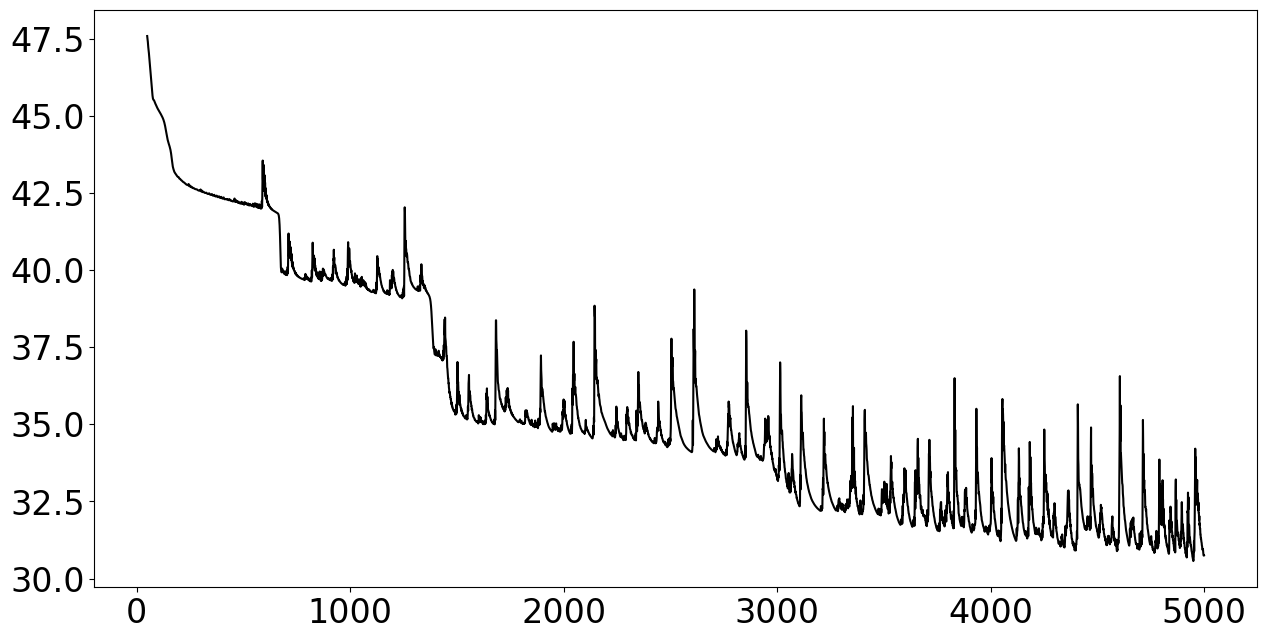

In [885]:
plt.plot(np.arange(n_iters)[50:],losses[50:],'-k')

In [886]:
tt=flow.sample(10000)
tt=np.exp(np.squeeze(tt.detach().numpy()))
tt=tt/np.sum(tt,axis=-1)[:,np.newaxis]

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_65701/818460540.py:2: RuntimeWarning: overflow encountered in exp
  tt=np.exp(np.squeeze(tt.detach().numpy()))
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_65701/818460540.py:3: RuntimeWarning: invalid value encountered in divide
  tt=tt/np.sum(tt,axis=-1)[:,np.newaxis]


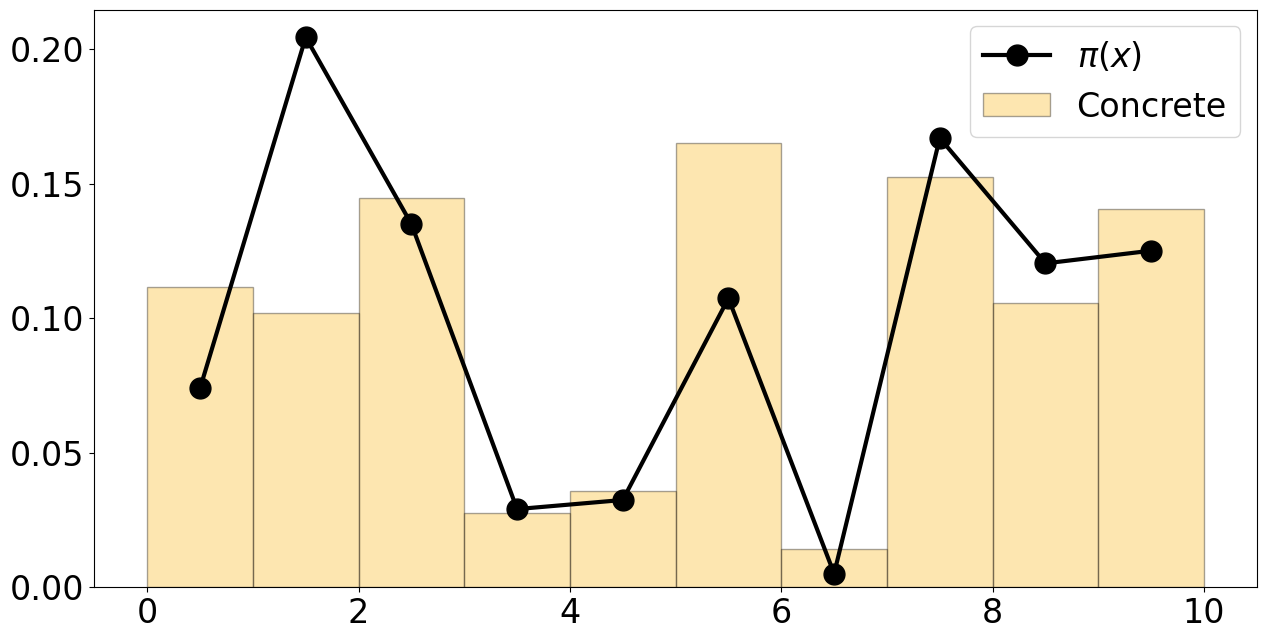

In [894]:
ttx=np.arange(0,K1)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.hist(np.argmax(tt,axis=-1),density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Concrete', color="#FBB91FFF",ec='black')
plt.legend()
#plt.ylim(0,0.5)

In [888]:
tt2=plt.hist(np.argmax(tt,axis=-1),density=True)
plt.clf()

<Figure size 1500x750 with 0 Axes>

In [889]:
tt2[0]/np.sum(tt2[0])

array([0.1115, 0.102 , 0.1448, 0.0276, 0.0358, 0.1653, 0.0144, 0.1525,
       0.1056, 0.1405])

In [890]:
prbs

array([0.07393561, 0.20446061, 0.13502975, 0.02906925, 0.03245506,
       0.10743913, 0.00507227, 0.16699829, 0.12041089, 0.12512913])

## Lyndon Duong
https://www.lyndonduong.com/realnvp/

In [924]:
class Coupling(nn.Module):
    """Two fully-connected deep nets ``s`` and ``t``, each with num_layers layers and
    The networks will expand the dimensionality up from 2D to 256D, then ultimately
    push it back down to 2D.
    """
    def __init__(self, input_dim=10, mid_channels=256, num_layers=5):
        super().__init__()
        self.input_dim = input_dim
        self.mid_channels = mid_channels
        self.num_layers = num_layers

        #  scale and translation transforms
        self.s = nn.Sequential(*self._sequential(), nn.Tanh())
        self.t = nn.Sequential(*self._sequential())

    def _sequential(self):
        """Compose sequential layers for s and t networks"""
        input_dim, mid_channels, num_layers = self.input_dim, self.mid_channels, self.num_layers
        sequence = [nn.Linear(input_dim, mid_channels), nn.ReLU()]  # first layer
        for _ in range(num_layers - 2):  # intermediate layers
            sequence.extend([nn.Linear(mid_channels, mid_channels), nn.ReLU()])
        sequence.extend([nn.Linear(mid_channels, input_dim)])  # final layer
        return sequence

    def forward(self, x):
        """outputs of s and t networks"""
        return self.s(x), self.t(x)


class myRealNVP(nn.Module):
    """Creates an invertible network with ``num_coupling_layers`` coupling layers
    We model the latent space as a N(0,I) Gaussian, and compute the loss of the
    network as the negloglik in the latent space, minus the log det of the jacobian.
    The network is carefully crafted such that the logdetjac is trivially computed.
    """
    def __init__(self, num_coupling_layers):
        super().__init__()
        self.num_coupling_layers = num_coupling_layers

        # model the latent as a
        #self.distribution = dists.MultivariateNormal(loc=torch.zeros(2),
        #                                             covariance_matrix=torch.eye(2))
        self.distribution = ExpRelaxedCategorical(torch.tensor([0.1]),torch.tensor(np.ones(K1)/K1))
        #self.masks = torch.tensor(
        #   [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype=torch.float32
        #)
        m=np.tril(np.ones((K1,K1)))-np.eye(K1)
        m[0,0]=1
        self.masks = torch.from_numpy(m.astype(np.float32))

        # create num_coupling_layers layers in the RealNVP network
        self.layers_list = [Coupling() for _ in range(num_coupling_layers)]

    def forward(self, x, training=True):
        """Compute the forward or inverse transform
        The direction in which we go (input -> latent vs latent -> input) depends on
        the ``training`` param.
        """
        log_det_inv = 0.
        direction = 1
        if training:
            direction = -1

        # pass through each coupling layer (optionally in reverse)
        for i in range(self.num_coupling_layers)[::direction]:
            mask =  self.masks[i]
            x_masked = x * mask
            reversed_mask = 1. - mask
            s, t = self.layers_list[i](x_masked)
            s = s * reversed_mask
            t = t * reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * torch.exp(direction * s) + direction * t * torch.exp(gate * s))
                + x_masked
            )
            # log det (and its inverse) are easily computed
            log_det_inv = log_det_inv + gate * s.sum(dim=-1)
        return x, log_det_inv

    def log_loss(self, x):
        """log loss is the neg loglik minus the logdet"""
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -torch.mean(log_likelihood)

mdl = myRealNVP(num_coupling_layers=3)

In [925]:
params = []
for l in mdl.layers_list:
    params.extend([p for p in l.parameters()])

optim = torch.optim.Adam(params, lr=1e-3)

losses = []

num_epochs = 1000
n_pts = 512
x0 = target.sample((1000,)).float()
for t in range(num_epochs):
    loss = mdl.log_loss(x0)
    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.detach())
    if t % 100 == 0: print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 58.528
iter 100: loss = 35.905
iter 200: loss = 35.460
iter 300: loss = 35.379
iter 400: loss = 35.277
iter 500: loss = 35.259
iter 600: loss = 35.117
iter 700: loss = 35.040
iter 800: loss = 34.967
iter 900: loss = 34.967


In [926]:
samples,_=mdl.forward(prior.sample((1000,)).float())
samples=np.exp(np.squeeze(samples.detach().numpy()))
samples=samples/np.sum(samples,axis=-1)[:,np.newaxis]

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_65701/1418362653.py:2: RuntimeWarning: overflow encountered in exp
  samples=np.exp(np.squeeze(samples.detach().numpy()))
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_65701/1418362653.py:3: RuntimeWarning: invalid value encountered in divide
  samples=samples/np.sum(samples,axis=-1)[:,np.newaxis]


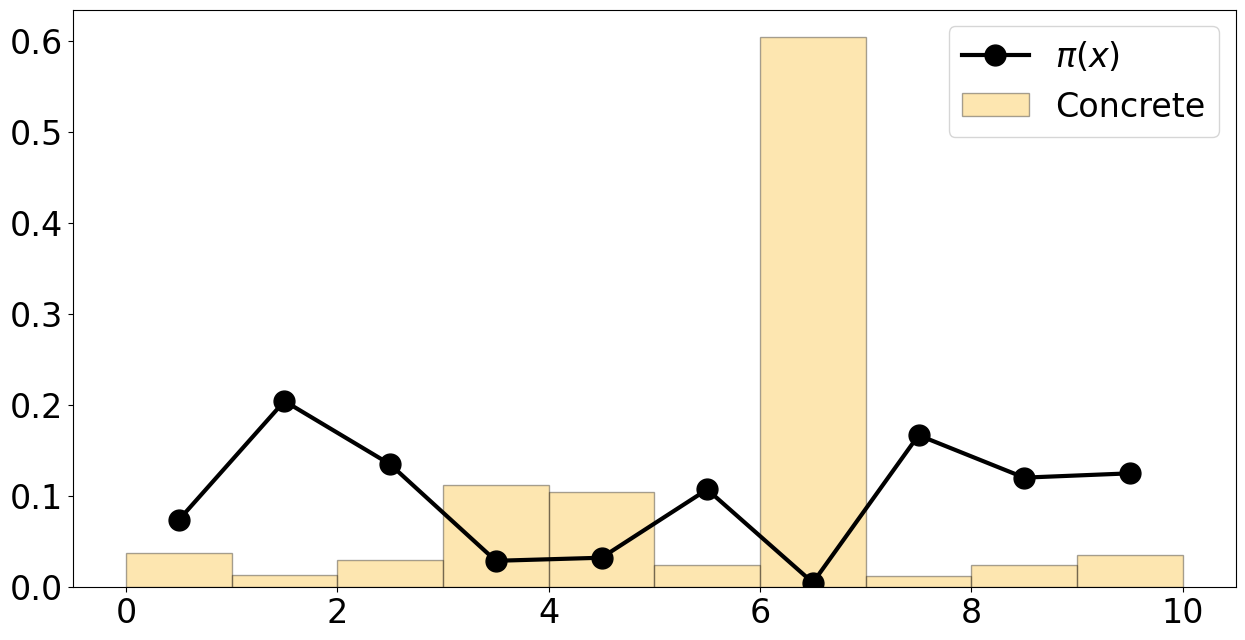

In [929]:
ttx=np.arange(0,K1)
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.hist(np.argmax(samples,axis=-1),density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Concrete', color="#FBB91FFF",ec='black')
plt.legend()
#plt.ylim(0,0.5)

## Another one

In [151]:
import torch
import flowtorch.bijectors as bij
import flowtorch.distributions as dist

In [ ]:
import flowtorch.parameters as params
# Lazily instantiated flow plus base and target distributions
params = params.DenseAutoregressive(hidden_dims=(32,))
bijectors = bij.AffineAutoregressive(params)#params=params)
base_dist = torch.distributions.Independent(torch.distributions.RelaxedOneHotCategorical(
      torch.tensor([temperature]),
      torch.tensor(np.ones(K1)/K1)),0)
target_dist = torch.distributions.Independent(torch.distributions.RelaxedOneHotCategorical(
      torch.tensor([temperature]),
      torch.tensor(prbs)),0)

# Instantiate transformed distribution and parameters
flow = dist.Flow(base_dist, bijectors)

# Training loop
opt = torch.optim.Adam(flow.parameters(), lr=5e-3)
frame = 0
for idx in range(3001):
    opt.zero_grad()

    # Minimize KL(q || p)
    y = base_dist.sample((1000,)).to(torch.float32)
    print(flow.bijector.inverse(y))
    loss = -flow.log_prob(y).mean()

    if idx % 500 == 0:
        print('epoch', idx, 'loss', loss)
        
    loss.backward()
    opt.step()